In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from scipy.stats import pearsonr, spearmanr

from scipy.stats import pearsonr

#import seaborn as sns

from matplotlib import colors

import editdistance

def subselect_list(li, ixs) :
    return [
        li[ixs[k]] for k in range(len(ixs))
    ]

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()


Using TensorFlow backend.


In [2]:
#Load APA plasmid data (random mpra)
file_path = '../../../../aparent/data/apa_plasmid_data/apa_plasmid_data'

plasmid_dict = isoio.load(file_path)

plasmid_df = plasmid_dict['plasmid_df']
plasmid_cuts = plasmid_dict['plasmid_cuts']

print("len(plasmid_df) = " + str(len(plasmid_df)))


len(plasmid_df) = 3818077


In [3]:
#Filter data
kept_libraries = [22]
min_count = 20

if kept_libraries is not None :
    keep_index = np.nonzero(plasmid_df.library_index.isin(kept_libraries))[0]
    plasmid_df = plasmid_df.iloc[keep_index].copy()
    plasmid_cuts = plasmid_cuts[keep_index, :]

if min_count is not None :
    keep_index = np.nonzero(plasmid_df.total_count >= min_count)[0]
    plasmid_df = plasmid_df.iloc[keep_index].copy()
    plasmid_cuts = plasmid_cuts[keep_index, :]

print("len(plasmid_df) = " + str(len(plasmid_df)) + " (filtered)")


len(plasmid_df) = 487402 (filtered)


In [4]:
#Calculate isoform ratios and log odds

pseudo_c = 1.0

prox_c = np.ravel(plasmid_cuts[:, 180+80:180+80+25].sum(axis=-1))
total_c = np.ravel(plasmid_cuts[:, 180:180+205].sum(axis=-1)) + np.ravel(plasmid_cuts[:, -1].todense())

plasmid_df['proximal_count_from_cuts'] = prox_c + pseudo_c
plasmid_df['total_count_from_cuts'] = total_c + 2. * pseudo_c

plasmid_df['proximal_usage'] = plasmid_df['proximal_count_from_cuts'] / plasmid_df['total_count_from_cuts']
plasmid_df['proximal_logodds'] = np.log(plasmid_df['proximal_usage'] / (1. - plasmid_df['proximal_usage']))


In [5]:
#Shuffle dataset and pick 50,000 datapoints for the test set

n_test = 50000

shuffle_index = np.arange(len(plasmid_df))
np.random.shuffle(shuffle_index)

plasmid_df_shuffled = plasmid_df.iloc[shuffle_index].copy().reset_index(drop=True)

plasmid_df_train = plasmid_df_shuffled.iloc[:-n_test].copy().reset_index(drop=True)
plasmid_df_test = plasmid_df_shuffled.iloc[-n_test:].copy().reset_index(drop=True)


In [2]:
#Get list of sequences and measured values

use_cached_version = True

seqs_train = None
seqs_test = None
y_train = None
y_test = None

if use_cached_version :
    seqs_train = pd.read_csv("apa_simple_seqs_train.csv", sep="\t")["seq"].values.tolist()
    seqs_test = pd.read_csv("apa_simple_seqs_test.csv", sep="\t")["seq"].values.tolist()
    y_train = np.ravel(pd.read_csv("apa_simple_seqs_train.csv", sep="\t")["logodds"].values)
    y_test = np.ravel(pd.read_csv("apa_simple_seqs_test.csv", sep="\t")["logodds"].values)
else :
    seqs_train = plasmid_df_train['padded_seq'].str.slice(180+25-5, 180+25+147+5).values.tolist()
    seqs_test = plasmid_df_test['padded_seq'].str.slice(180+25-5, 180+25+147+5).values.tolist()

    logodds_train = plasmid_df_train['proximal_logodds'].values.tolist()
    logodds_test = plasmid_df_test['proximal_logodds'].values.tolist()

    seqs_train_df = pd.DataFrame({'seq' : seqs_train, 'logodds' : logodds_train})
    seqs_train_df.to_csv("apa_simple_seqs_train.csv", sep="\t", index=False)

    seqs_test_df = pd.DataFrame({'seq' : seqs_test, 'logodds' : logodds_test})
    seqs_test_df.to_csv("apa_simple_seqs_test.csv", sep="\t", index=False)

print("len(seqs_train) = " + str(len(seqs_train)))
print("len(seqs_test) = " + str(len(seqs_test)))


len(seqs_train) = 437402
len(seqs_test) = 50000


In [3]:
#Extract subset of data with canonical pas hexamers

pas_1_train = [seqs_train[i][50:50 + 6] for i in range(len(seqs_train))]
pas_2_train = [seqs_train[i][50 + 45 + 6:50 + 45 + 6 + 6] for i in range(len(seqs_train))]

pas_1_test = [seqs_test[i][50:50 + 6] for i in range(len(seqs_test))]
pas_2_test = [seqs_test[i][50 + 45 + 6:50 + 45 + 6 + 6] for i in range(len(seqs_test))]

cano_pas_1_train = np.array([1 if pas_1_train[i] == 'AATAAA' else 0 for i in range(len(pas_1_train))])
cano_pas_2_train = np.array([1 if pas_2_train[i] == 'AATAAA' else 0 for i in range(len(pas_2_train))])

cano_pas_1_test = np.array([1 if pas_1_test[i] == 'AATAAA' else 0 for i in range(len(pas_1_test))])
cano_pas_2_test = np.array([1 if pas_2_test[i] == 'AATAAA' else 0 for i in range(len(pas_2_test))])

seqs_train = [seqs_train[i] for i in range(len(seqs_train)) if (cano_pas_1_train[i] == 1) and (cano_pas_2_train[i] == 1)]
seqs_test = [seqs_test[i] for i in range(len(seqs_test)) if (cano_pas_1_test[i] == 1) and (cano_pas_2_test[i] == 1)]
y_train = y_train[(cano_pas_1_train == 1) & (cano_pas_2_train == 1)]
y_test = y_test[(cano_pas_1_test == 1) & (cano_pas_2_test == 1)]

print("len(seqs_train) = " + str(len(seqs_train)))
print("len(seqs_test) = " + str(len(seqs_test)))

print("len(y_train) = " + str(len(y_train)))
print("len(y_test) = " + str(len(y_test)))


len(seqs_train) = 86015
len(seqs_test) = 9761
len(y_train) = 86015
len(y_test) = 9761


In [28]:
#Train a k-NN ensemble

use_cached_version = True

n_nn = 5
nn_size = 25000
nn_neighbors = 50

nn_encoder = IdentityEncoder(96, {'A':0, 'C':1, 'G':2, 'T':3})

if use_cached_version :
    boosted_grad = pickle.load(open("apa_simple_knn_n_nn_" + str(n_nn) + "_nn_size_" + str(nn_size) + "_nn_neighbors_" + str(nn_neighbors) + ".pickle", "rb"))["nns"]
else :
    nns = []
    for nn_ix in range(n_nn) :
        print("Fitting NN Model " + str(nn_ix) + "...")

        shuffle_index = np.arange(len(seqs_train))
        np.random.shuffle(shuffle_index)

        chosen_index = shuffle_index[:nn_size]

        nn_x = [np.reshape(nn_encoder(seqs_train[i][5:5+96]), (1, 96 * 4)) for i in chosen_index.tolist()]
        nn_x = np.concatenate(nn_x, axis=0)

        nn_y = y_train[chosen_index]

        nn = KNeighborsRegressor(n_neighbors=nn_neighbors)
        nns.append(nn.fit(nn_x, nn_y))
    
    pickle.dump({
        "nns" : nns
    }, open("apa_simple_knn_n_nn_" + str(n_nn) + "_nn_size_" + str(nn_size) + "_nn_neighbors_" + str(nn_neighbors) + ".pickle", "wb"))

print(nns)


[KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=50, p=2,
          weights='uniform'), KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=50, p=2,
          weights='uniform'), KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=50, p=2,
          weights='uniform'), KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=50, p=2,
          weights='uniform'), KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=50, p=2,
          weights='uniform')]


-- k-NN Model (Test data) --
pearson-r correlation = 0.436
pearson-r p = 0.0


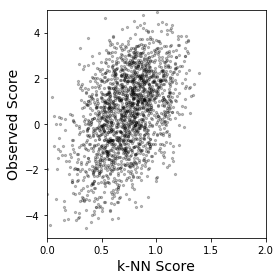

In [30]:
#Predict on data using k-NN model

n_to_test = 2000

nn_x = [np.reshape(nn_encoder(seqs_test[i][5:5+96]), (1, 96 * 4)) for i in range(min(len(seqs_test), n_to_test))]
nn_x = np.concatenate(nn_x, axis=0)

nn_scores = []
for nn_ix in range(len(nns)) :
    nn = nns[nn_ix]

    nn_score = nn.predict(nn_x).reshape(-1, 1)
    nn_scores.append(nn_score)

nn_scores = np.concatenate(nn_scores, axis=-1)
nn_scores = np.mean(nn_scores, axis=-1)

print("-- k-NN Model (Test data) --")

y_test_hat = nn_scores

print("pearson-r correlation = " + str(round(pearsonr(y_test_hat, y_test[:y_test_hat.shape[0]])[0], 4)))
print("pearson-r p = " + str(round(pearsonr(y_test_hat, y_test[:y_test_hat.shape[0]])[1], 4)))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_test_hat, y_test[:y_test_hat.shape[0]], s=5, color='black', alpha=0.25)

plt.xlim(0, 2)
plt.ylim(-5, 5)

plt.xlabel("k-NN Score", fontsize=14)
plt.ylabel("Observed Score", fontsize=14)

plt.tight_layout()
plt.show()


In [4]:
#Encode training and test flat-one-hot matrices

nn_encoder = IdentityEncoder(96, {'A':0, 'C':1, 'G':2, 'T':3})

flat_train = [np.reshape(nn_encoder(seqs_train[i][5:5+96]), (1, 96 * 4)) for i in range(len(seqs_train))]
flat_train = np.concatenate(flat_train, axis=0)

flat_test = [np.reshape(nn_encoder(seqs_test[i][5:5+96]), (1, 96 * 4)) for i in range(len(seqs_test))]
flat_test = np.concatenate(flat_test, axis=0)


In [24]:
#Train a boosted model on one-hot nucleotide features

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

use_cached_version = True

max_iter = 256
max_depth = 12
max_leaf_nodes = 31

if use_cached_version :
    boosted_grad = pickle.load(open("apa_simple_flat_boosted_grad_max_iter_" + str(max_iter) + "_max_depth_" + str(max_depth) + "_max_leaf_nodes_" + str(max_leaf_nodes) + ".pickle", "rb"))["boosted_grad"]
else :
    boosted_grad = HistGradientBoostingRegressor(
        max_iter=max_iter,
        learning_rate=0.1,
        max_depth=max_depth,
        max_leaf_nodes=max_leaf_nodes,
        loss='least_squares',
        verbose=1
    ).fit(
        flat_train,
        y_train
    )
    
    pickle.dump({
        "boosted_grad" : boosted_grad
    }, open("apa_simple_flat_boosted_grad_max_iter_" + str(max_iter) + "_max_depth_" + str(max_depth) + "_max_leaf_nodes_" + str(max_leaf_nodes) + ".pickle", "wb"))

print(boosted_grad)


HistGradientBoostingRegressor(max_depth=12, max_iter=256, verbose=1)


-- Boosted Nt Model (Training data) --
pearson-r correlation = 0.6456
pearson-r p = 0.0


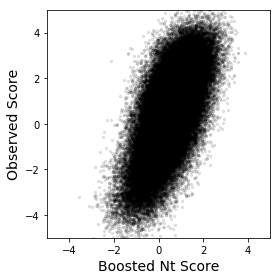

-- Boosted Nt Model (Test data) --
pearson-r correlation = 0.5317
pearson-r p = 0.0


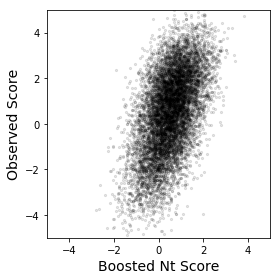

In [25]:
#Predict on data using boosted k-mer model

print("-- Boosted Nt Model (Training data) --")

y_train_hat = boosted_grad.predict(flat_train)

print("pearson-r correlation = " + str(round(pearsonr(y_train_hat, y_train)[0], 4)))
print("pearson-r p = " + str(round(pearsonr(y_train_hat, y_train)[1], 4)))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_train_hat, y_train, s=5, color='black', alpha=0.1)

plt.xlim(-5, 5)
plt.ylim(-5, 5)

plt.xlabel("Boosted Nt Score", fontsize=14)
plt.ylabel("Observed Score", fontsize=14)

plt.tight_layout()
plt.show()

print("-- Boosted Nt Model (Test data) --")

y_test_hat = boosted_grad.predict(flat_test)

print("pearson-r correlation = " + str(round(pearsonr(y_test_hat, y_test)[0], 4)))
print("pearson-r p = " + str(round(pearsonr(y_train_hat, y_train)[1], 4)))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_test_hat, y_test, s=5, color='black', alpha=0.1)

plt.xlim(-5, 5)
plt.ylim(-5, 5)

plt.xlabel("Boosted Nt Score", fontsize=14)
plt.ylabel("Observed Score", fontsize=14)

plt.tight_layout()
plt.show()
